In [5]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import numpy as np
import math
import matplotlib.pyplot as plt

In [6]:
device_id = 1
device_name = f'cuda:{device_id}' if torch.cuda.is_available() else 'cpu'
DEVICE = torch.device(device_name)
print('Using {} device'.format(DEVICE))

Using cuda:1 device


In [7]:
def set_random_seed(seed):
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
set_random_seed(2)

In [8]:
class Drift(nn.Module):
    def __init__(self, input_dim):
        super(Drift, self).__init__()
        self.embedder = torch.nn.Sequential(
            torch.nn.Linear(input_dim+1, 2000),
            torch.nn.ReLU(),
            torch.nn.Linear(2000, 1000),
            torch.nn.ReLU(),
            torch.nn.Linear(1000, 500),
            torch.nn.ReLU(),
            torch.nn.Linear(500, 500),
            torch.nn.ReLU(),
            torch.nn.Linear(500, 500),
            torch.nn.ReLU(),
            torch.nn.Linear(500, 100),
            torch.nn.ReLU(),
            torch.nn.Linear(100, input_dim)
        )
    
    def forward(self, x_t, t):
        if isinstance(t, (int, float)):
            n = x_t.size(0)
            T = t*torch.ones((n, 1)).float().to(DEVICE)
            X = torch.cat((x_t, T), dim=1)
        elif isinstance(t, torch.Tensor):
            X = torch.cat((x_t, t), dim=1)
        return self.embedder(X)

class drift_gaussian_gaussian(nn.Module):
    def __init__(self, mu0, mu1, sigma2_0, sigma2_1):
        super(drift_gaussian_gaussian, self).__init__()
        self.mu0 = mu0
        self.mu1 = mu1
        self.sigma2_0 = sigma2_0
        self.sigma2_1 = sigma2_1

    def score(self, x_t, t):
        sigma2_t = self.sigma2_1*t*t + self.sigma2_0*(1-t)*(1-t)
        mu_t = self.mu1*t + self.mu0*(1-t)
        s_t = (t*mu_t - x_t)/sigma2_t

        return s_t
    
    def forward(self, x_t, t):
        if t==1.0:
            return x_t - self.mu0
        elif t==0.0:
            return self.mu1 - x_t
        else:
            v_t = x_t/t + ((1-t)/t)*self.score(x_t, t)
            return v_t
        
class CustomDataset(Dataset):
    def __init__(self, X, Z):
        self.X = X
        self.Z = Z

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.Z[idx]

In [9]:
# Training loop

def train(model, num_epochs, dataloader, save_loss):
    for epoch in range(num_epochs):
        epoch_loss = 0.0
        num_batches = 0

        for batch in dataloader:
            x, z = batch
            m, d = z.size(0), z.size(1)

            # perm = torch.randperm(m)
            # x = x[perm, :].to(DEVICE).float()
            # z = z[perm, :].to(DEVICE).float()
            
            x = x.to(DEVICE).float()
            z = z.to(DEVICE).float() 

            x = x.unsqueeze(0).repeat(m, 1, 1).reshape(-1, d)
            z = z.unsqueeze(1).repeat(1, m, 1).reshape(-1, d)

            t = torch.from_numpy(np.random.uniform(0, 1, z.size(0))).to(DEVICE).float().view(-1, 1)
            x_t = t*x + (1-t)*z

            # Zero the parameter gradients
            model_optimizer.zero_grad()

            # Compute loss
            loss = criterion(model(x_t, t), (x-z))

            # Backward pass and optimize
            loss.backward()
            model_optimizer.step()
            
            # Accumulate loss
            epoch_loss += loss.item()
            num_batches += 1
        
        # Calculate and print average loss for the epoch
        avg_loss = epoch_loss / num_batches
        print(f'Epoch [{epoch+1}/{num_epochs}], Average Loss: {avg_loss:.4f}')

        # Step the scheduler with the average loss
        scheduler.step(avg_loss)

        save_loss.append(avg_loss)
    
    return save_loss


def plot_loss(save_loss):
    plt.figure(figsize=(10, 6))
    plt.plot(save_loss, marker='o', linestyle='-', color='b')
    plt.title('Loss per Epoch')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.grid(True)
    plt.show()
    plt.close()
    return

In [10]:
def sample(model, T, num_samples, input_dim):
    Z_0_np = np.random.multivariate_normal(np.zeros(input_dim), np.eye(input_dim), num_samples)

    Z_0 = torch.from_numpy(Z_0_np).to(DEVICE).float()

    with torch.no_grad():
        trajectory = Z_0.unsqueeze(0).repeat(T+1, 1, 1)
        ones = torch.ones((num_samples, 1)).float().to(DEVICE)
        drift_save = model(trajectory[0, :, :], 0*ones).repeat(T+1, 1, 1)

        for i in range(1, T+1):
            t_i_minus_1 = ones*(i-1)/T
            trajectory[i, :, :] = trajectory[i-1, :, :] + model(trajectory[i-1, :, :], t_i_minus_1)/T
            drift_save[i, :, :] = model(trajectory[i-1, :, :], t_i_minus_1)
    return trajectory, drift_save

def plot_trajectories(trajectory, plot_paths=True):
    trajectory_np = trajectory.cpu().numpy()
    (T, n, d) = trajectory.shape
    if plot_paths:
        for i in range(n):
            particle_trajectory = trajectory_np[:, i, :]
            plt.plot(particle_trajectory[:, 0], particle_trajectory[:, 1], alpha=0.1, color="purple")
            
    plt.scatter(trajectory_np[T-1, :, 0], trajectory_np[T-1, :, 1], label="End points", color="green")
    plt.scatter(trajectory_np[0, :, 0], trajectory_np[0, :, 1], label="Initial points", color="orange")
    plt.scatter(X_np[:, 0], X_np[:, 1], label="Original data points", color="blue", alpha=0.05)
    
    plt.title('Trajectories of particles over time, T={}'.format(T-1))
    plt.legend()
    plt.show()
    plt.close()
    return

In [28]:
input_dim = 2
num_samples = 5000

Z_np = np.random.multivariate_normal(np.zeros(input_dim), np.eye(input_dim), num_samples)

mean1 = [5, 9]
cov1 = [[3, -1], [-1, 1]]

mean2 = [8, 3]
cov2 = [[0.2, 2], [2, 10]]

# Mixing proportions
weights = [0.3, 0.7]

# Determine the number of samples from each component
num_samples_component = np.random.multinomial(num_samples, weights)

# Generate the samples
X_np = np.vstack([
    np.random.multivariate_normal(mean1, cov1, num_samples_component[0]),
    np.random.multivariate_normal(mean2, cov2, num_samples_component[1])
])
np.random.shuffle(X_np)


/tmp/ipykernel_3558706/1355534818.py:21: RuntimeWarning: covariance is not symmetric positive-semidefinite.
  np.random.multivariate_normal(mean2, cov2, num_samples_component[1])


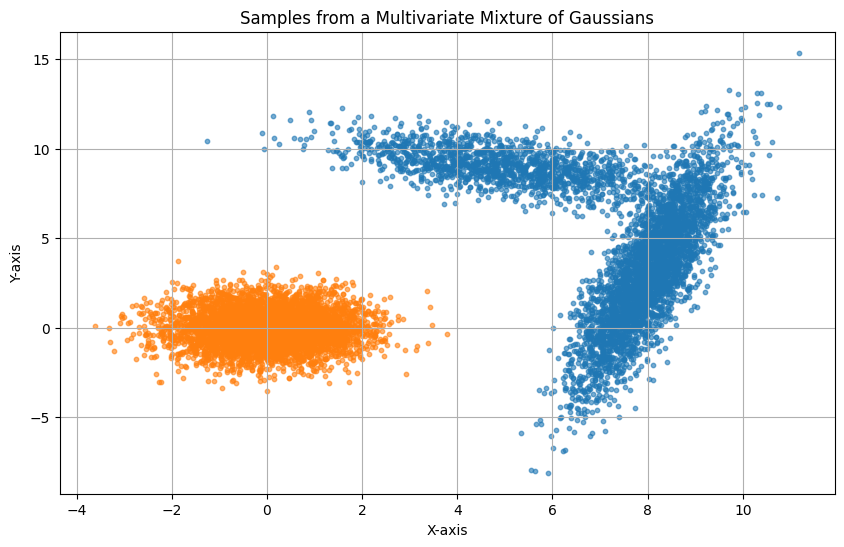

In [29]:
# Plot the samples
plt.figure(figsize=(10, 6))
plt.scatter(X_np[:, 0], X_np[:, 1], s=10, alpha=0.6)
plt.scatter(Z_np[:, 0], Z_np[:, 1],  s=10, alpha=0.6)
plt.title('Samples from a Multivariate Mixture of Gaussians')
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.grid(True)
plt.show()

In [30]:
X = torch.from_numpy(X_np)
Z = torch.from_numpy(Z_np)

# Create an instance of the custom dataset
dataset = CustomDataset(X, Z)

# Create a DataLoader
batch_size = 512
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

In [32]:
from torch.optim.lr_scheduler import ReduceLROnPlateau
import torch.optim as optim

model = Drift(input_dim).to(DEVICE).float()

criterion = nn.MSELoss()
# model_optimizer = optim.Adam(model.parameters(), lr=0.001)
model_optimizer = optim.Adam(model.parameters(), lr=0.01)
save_loss = []
num_epochs = 70
scheduler = ReduceLROnPlateau(model_optimizer, mode='min', factor=0.2, patience=5, verbose=True)

In [33]:
save_loss = train(model, num_epochs, dataloader, save_loss)

Epoch [1/70], Average Loss: 27571.7055
Epoch [2/70], Average Loss: 15.9422
Epoch [3/70], Average Loss: 12.7549
Epoch [4/70], Average Loss: 9.1721
Epoch [5/70], Average Loss: 6.2762
Epoch [6/70], Average Loss: 5.0024
Epoch [7/70], Average Loss: 4.7419
Epoch [8/70], Average Loss: 4.7189
Epoch [9/70], Average Loss: 4.6708
Epoch [10/70], Average Loss: 4.5953
Epoch [11/70], Average Loss: 4.4961
Epoch [12/70], Average Loss: 4.6040
Epoch [13/70], Average Loss: 4.6257
Epoch [14/70], Average Loss: 4.4820
Epoch [15/70], Average Loss: 4.4480
Epoch [16/70], Average Loss: 4.7830
Epoch [17/70], Average Loss: 4.8194
Epoch [18/70], Average Loss: 4.5494
Epoch [19/70], Average Loss: 4.3590
Epoch [20/70], Average Loss: 4.5087
Epoch [21/70], Average Loss: 4.6510
Epoch [22/70], Average Loss: 4.5376
Epoch [23/70], Average Loss: 4.5517
Epoch [24/70], Average Loss: 4.5073
Epoch [25/70], Average Loss: 4.3107
Epoch [26/70], Average Loss: 4.3347
Epoch [27/70], Average Loss: 4.8747
Epoch [28/70], Average Loss: 4.

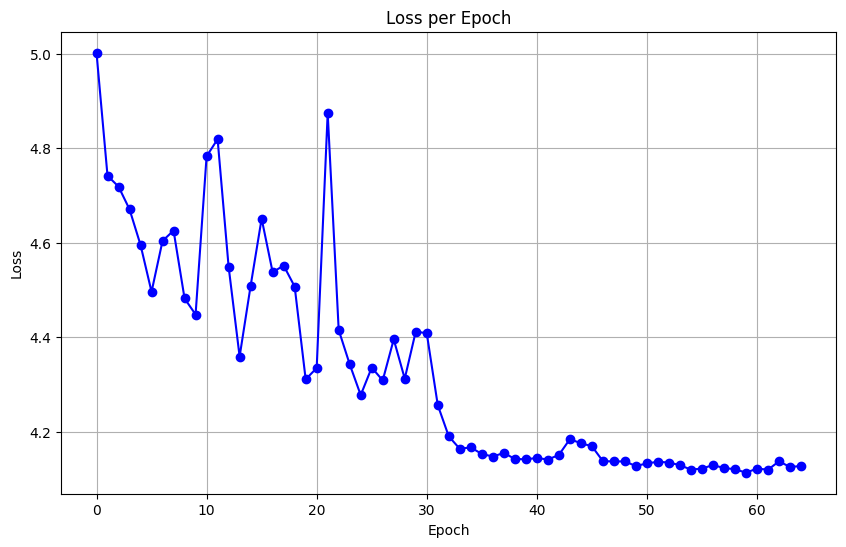

In [34]:
plot_loss(save_loss[5:])

In [35]:
set_random_seed(2)

# T euler steps
mu1 = torch.tensor(mean1).float().to(DEVICE)
mu0 = torch.tensor([0, 0]).float().to(DEVICE)

true_drift = drift_gaussian_gaussian(mu0, mu1, 1, 1)
T = 100
num_samples = 2000
trajectory, save_drift = sample(model, T, num_samples, 2)

In [37]:
import ot
num_steps = 50
# set_random_seed(2)
steps = np.arange(num_steps)+1
distance = np.zeros(num_steps)
num_samples = 1000
for t in steps:
    trajectory, save_drift = sample(model, t, num_samples, 2)


    # Example data: two sets of points in 2D
    X = X_np  # 100 points in 2D
    Y = trajectory[-1, :, :].cpu().numpy()  # 100 points in 2D

    # Create uniform weights (each point has equal weight)
    a = np.ones(X.shape[0]) / X.shape[0]
    b = np.ones(Y.shape[0]) / Y.shape[0]

    # Compute squared Wasserstein-2 distance
    distance[t-1] = ot.emd2(a, b, ot.dist(X, Y))


/datastor1/vansh/conda_install/miniconda3/envs/ml/lib/python3.12/site-packages/ot/lp/__init__.py:580: UserWarning: numItermax reached before optimality. Try to increase numItermax.
  check_result(result_code)


np.float64(-1.515162876971642)

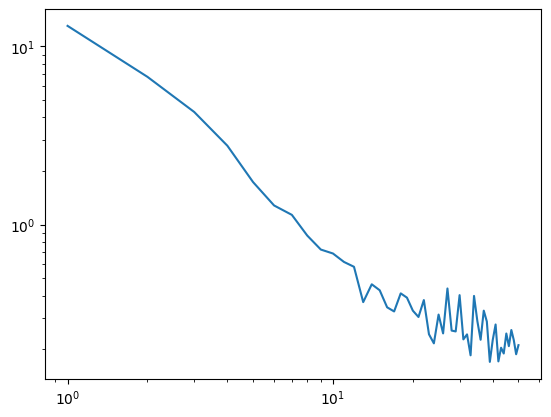

In [38]:
plt.plot(steps, distance)
# plt.plot(steps, np.exp(log_d_2))
# Set the x-axis to a logarithmic scale
plt.xscale('log')

# Optionally, set the y-axis to a logarithmic scale as well
plt.yscale('log')
from math import log

log_d = np.log(distance)
log_t = np.log(steps)


h=2
(log_d[h+1] - log_d[h])/(log_t[h+1] - log_t[h])

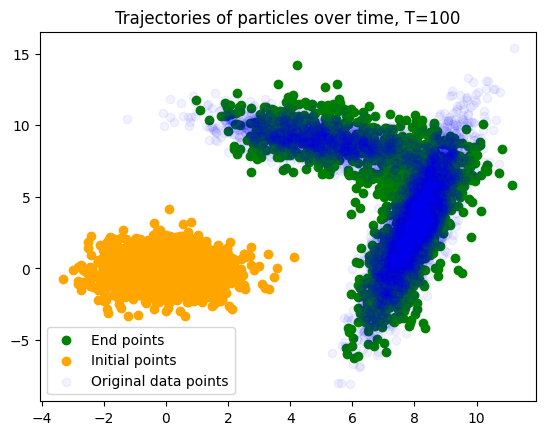

In [36]:
plot_trajectories(trajectory, plot_paths=False)

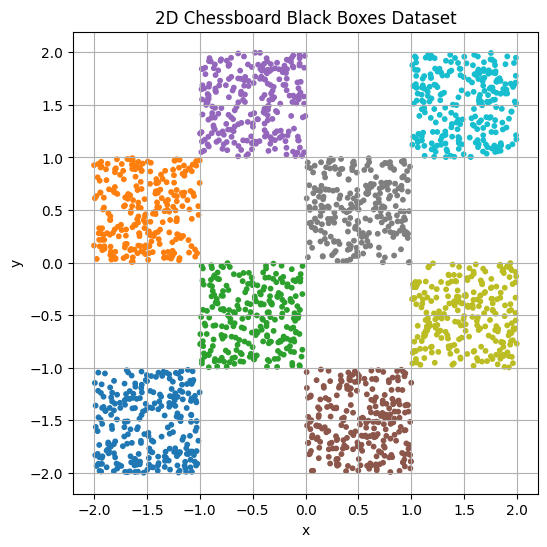

In [96]:
def generate_chessboard_black_boxes(n_samples=2000, noise=0.1):
    # Create the data grid for the black boxes only
    x = []
    y = []
    labels = []
    color_idx = 0

    for i in range(-2, 2):
        for j in range(-2, 2):
            if (i + j) % 2 == 0:  # Condition for black boxes
                # Generate samples within the black box
                x_box = np.random.rand(n_samples//8) + i
                y_box = np.random.rand(n_samples//8) + j
                
                # Add noise to the points
                # x_box += np.random.normal(0, noise, n_samples//8)
                # y_box += np.random.normal(0, noise, n_samples//8)
                
                x.extend(x_box)
                y.extend(y_box)
                labels.extend([color_idx] * (n_samples//8))
                color_idx += 1
    
    return np.array(x), np.array(y), np.array(labels)

# Generate chessboard dataset with only black boxes filled
x_black, y_black, labels_black = generate_chessboard_black_boxes()

# Plotting the dataset
plt.figure(figsize=(6, 6))
plt.scatter(x_black, y_black, c=labels_black, cmap='tab10', s=10)
plt.title("2D Chessboard Black Boxes Dataset")
plt.xlabel("x")
plt.ylabel("y")
plt.grid(True)
plt.show()


In [18]:
X_1, Z_1 = trajectory[T, :, :], trajectory[0, :, :]

dataset_1 = CustomDataset(X_1, Z_1)
dataloader_1 = DataLoader(dataset_1, batch_size=batch_size, shuffle=True)

model_1 = Drift(input_dim).to(DEVICE).float()

criterion = nn.MSELoss()
# model_optimizer = optim.Adam(model.parameters(), lr=0.001)
model_optimizer = optim.Adam(model_1.parameters(), lr=0.01)

scheduler = ReduceLROnPlateau(model_optimizer, mode='min', factor=0.2, patience=5, verbose=True)

In [19]:
save_loss = train(model_1, num_epochs, dataloader_1)

Epoch [1/30], Average Loss: 108030.1275
Epoch [2/30], Average Loss: 9.8523
Epoch [3/30], Average Loss: 5.4815
Epoch [4/30], Average Loss: 2.8856
Epoch [5/30], Average Loss: 2.2885
Epoch [6/30], Average Loss: 2.2147
Epoch [7/30], Average Loss: 2.0689
Epoch [8/30], Average Loss: 2.0670
Epoch [9/30], Average Loss: 2.0133
Epoch [10/30], Average Loss: 2.0160
Epoch [11/30], Average Loss: 1.9832
Epoch [12/30], Average Loss: 1.9904
Epoch [13/30], Average Loss: 1.8938
Epoch [14/30], Average Loss: 1.8668
Epoch [15/30], Average Loss: 1.9715
Epoch [16/30], Average Loss: 1.9231
Epoch [17/30], Average Loss: 1.8991
Epoch [18/30], Average Loss: 1.8251
Epoch [19/30], Average Loss: 1.8655
Epoch [20/30], Average Loss: 1.8238
Epoch [21/30], Average Loss: 1.8292
Epoch [22/30], Average Loss: 1.7746
Epoch [23/30], Average Loss: 1.7667
Epoch [24/30], Average Loss: 1.7658
Epoch [25/30], Average Loss: 1.7876
Epoch [26/30], Average Loss: 1.7432
Epoch [27/30], Average Loss: 1.8697
Epoch [28/30], Average Loss: 1.7

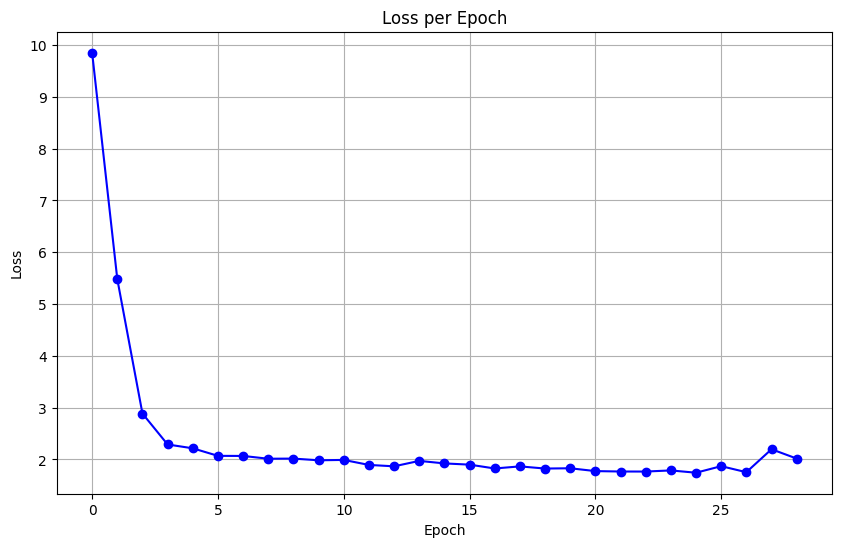

In [20]:
plot_loss(save_loss[1:])

In [23]:
T = 1000
trajectory_1, save_drift_1 = sample(model_1, T, num_samples)

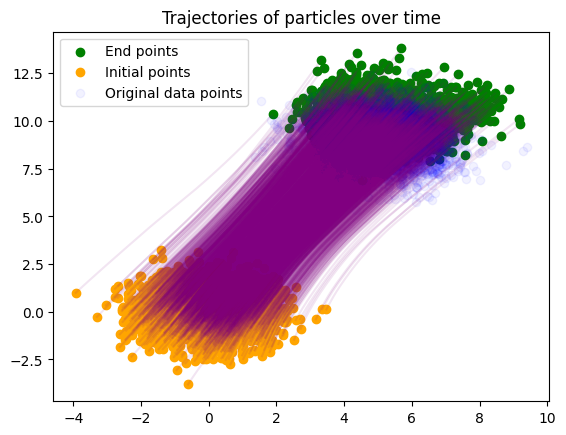

In [24]:
plot_trajectories(trajectory_1, plot_paths=True)